# Initial Setup

## Libraries

In [2]:
%%capture
!pip install soundfile

In [3]:
import warnings
import sys
warnings.filterwarnings('ignore')

import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)
 
import numpy as np
import scipy
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm_notebook
import soundfile as sf
 
import matplotlib.pyplot as plt
import IPython.display as ipd

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Activation, Conv1D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_squared_error
import tensorflow.keras.backend as kb

In [5]:
print("=== Library Versions ===")
print("SciPy:     ",scipy.__version__)
print("Numpy:     ",np.__version__)
print("TensorFlow:",tf.__version__)
print("Keras:     ",keras.__version__)
print("Soundfile: ",sf.__version__)

=== Library Versions ===
SciPy:      1.4.1
Numpy:      1.18.5
TensorFlow: 2.3.0
Keras:      2.4.0
Soundfile:  0.10.3


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Custom Functions

In [7]:
# Convolute two audio signals
def conv(source, impulse):
  split = source.split('.')
  conv_output = '.'.join(split[:-1])+'_conv.' + split[-1]
 
  clip_factor = 1.01 # clip factor default value
 
  h1, Fs1 = sf.read( impulse ) # impulse response
  x1, Fs2 = sf.read( source ) # file to process
 
  if Fs1 == Fs2 : # if sample rates are the same
    print("Processing...")
    y1 = signal.fftconvolve(x1,h1).real # takes the real part to avoid a too small complex part (around e-18)
 
    # audio normalization: if "y = y/max(y)" -> "values out of [-1,+1] range are clipped"
    y1 = y1/( max(y1)*clip_factor ) # to avoid clipping
    
    sf.write( conv_output, y1, Fs1 )
 
    print("Output file:", conv_output)
    print("Convolution success.")
 
    return conv_output
  else:
    print("Error: files has different sample rate.")

In [8]:
# Error-to-Signal Ratio
def ESR(y_actual,y_predicted):
    return kb.sum(kb.square(y_actual-y_predicted),axis=0)/(kb.sum(kb.square(y_actual),axis=0)+kb.epsilon())

In [9]:
class AudioSequence(Sequence):
  def __init__(self, x_set, y_set, batch_size, rec_field, shuffle=False):
    self.x, self.y = x_set, y_set
    self.rec_field = rec_field
    self.batch_size = batch_size
    self.shuffle = shuffle
 
     # Matrix, each column containing the previous N input samples
    self.batch_x = np.empty((self.batch_size ,self.rec_field,1))
    # Vector, each entry containing the current output samples
    self.batch_y = np.empty((self.batch_size ,1,1))
 
    self.order = np.arange(0, self.__len__())
 
    if self.shuffle:
      self.order = np.random.randint(0,self.__len__(),self.__len__())
 
  def __len__(self):
    return np.math.floor((len(self.x)-self.rec_field) / self.batch_size)
 
  def __getitem__(self, idx, ):
    batch = self.order[idx]*self.batch_size
   
    self.batch_x[:,:,0] = np.lib.stride_tricks.as_strided(
        self.x[batch:batch+self.rec_field+self.batch_size],
        (self.batch_size, self.rec_field), 
        (8, 8),
        writeable=False
    )
    self.batch_y[:,0,0] = self.y[batch+self.rec_field:batch+self.rec_field+self.batch_size]
 
    return np.array(self.batch_x), np.array(self.batch_y)
 
  def on_epoch_end(self):
    if self.shuffle:
      self.order = np.random.randint(0,self.__len__(),self.__len__())

In [10]:
def generate_dataset(audio_input, audio_amp, rec_field, samples=-1):
    if samples == -1 or samples < 0:
      samples = len(audio_input)-rec_field

    # Matrix, each column containing the previous N input samples
    X = np.empty((samples ,rec_field,1))
    # Vector, each entry containing the current output samples
    y = np.empty((samples ,1,1))
   
    X[:,:,0] = np.lib.stride_tricks.as_strided(
        audio_input,
        (samples, rec_field), 
        (8, 8),
        writeable=False
    )
    y[:,0,0] = audio_amp[rec_field:rec_field+samples]

    return X, y

In [11]:
def evaluate_tfmodel(name):
  LOAD_MODEL = '{}{:02}_Data/{}'.format(HOME_FOLDER, int(name[0:2]), name)
  print("Loading Model:", LOAD_MODEL)
  tflite_interpreter = tf.lite.Interpreter(model_path=LOAD_MODEL)

  tflite_interpreter.allocate_tensors()
  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details()

  input_scale, input_zero_point = input_details[0]["quantization"]
  output_scale, output_zero_point = output_details[0]["quantization"]
  REC_FIELD = input_details[0]['shape'][1]

  X,y  = generate_dataset(test_audio_input, test_audio_amp, REC_FIELD)

  if (input_scale == 0):
    input_scale = 1.0
  if (output_scale == 0):
    output_scale = 1.0

  X = X / input_scale + input_zero_point
  y = y / output_scale + output_zero_point

  output = np.zeros(len(test_audio_input)-REC_FIELD)

  STOP  = len(output)-(REC_FIELD//2+3)
  for i in tqdm_notebook(range(0,STOP)):
      tflite_interpreter.set_tensor(input_details[0]['index'], np.expand_dims(X[i], axis=0).astype(input_details[0]["dtype"]))
      tflite_interpreter.allocate_tensors()
      tflite_interpreter.invoke()
      output[i+REC_FIELD//2+3] = (tflite_interpreter.get_tensor(output_details[0]['index'])[:,0,0]-output_zero_point)*output_scale

  print("Test ESR: {:.2f}%".format(100*ESR(test_audio_amp[REC_FIELD//2+3:STOP], output[REC_FIELD//2+3:STOP])))

  return output

In [12]:
def evaluate_model(name):
  LOAD_MODEL = '{}{:02}_Data/{}'.format(HOME_FOLDER, int(name[0:2]), name)

  print("Loading Model:", LOAD_MODEL + '.h5')
  model = tf.keras.models.load_model(LOAD_MODEL, custom_objects={'ESR': ESR})
  seq_test  = AudioSequence(test_audio_input,  test_audio_amp,  BATCH_SIZE_PREDICT, model.input_shape[1])
  results = model.evaluate(seq_test, workers=1, max_queue_size=20, steps=np.floor(len(test_audio_input)/BATCH_SIZE_PREDICT), verbose=1)
  print("Test ESR: {:.2f}%".format(100*results))

In [13]:
def predict_model(name, start=0, end=1000):
  LOAD_MODEL = '{}{:02}_Data/{}'.format(HOME_FOLDER, int(name[0:2]), name)

  print("Loading Model:", LOAD_MODEL + '.h5')
  model = tf.keras.models.load_model(LOAD_MODEL, custom_objects={'ESR': ESR})
  seq_test  = AudioSequence(test_audio_input[start-model.input_shape[1]:end-model.input_shape[1]],  test_audio_amp[start+model.input_shape[1]:end+model.input_shape[1]], BATCH_SIZE_PREDICT, model.input_shape[1])

  output = model.predict(seq_test, workers=1, max_queue_size=20, steps=np.floor((end-start)/BATCH_SIZE_PREDICT), verbose=1)[:,0,0]
  return output

# Evaluation

In [14]:
# Neural Network
BATCH_SIZE_PREDICT = 1024

HOME_FOLDER = '/content/drive/MyDrive/Colab Notebooks/'
 

TRAIN_TEST_SPLIT = 0.85 # Use 60% for training
TRAIN_VAL_SPLIT  = 0.9 # Use another 60% of the remaining data for training and 30% for validation
 
TRAIN_AUDIO_IN  = HOME_FOLDER + 'Datasets/OrangeMicroDark/OrangeMicroDark_in.wav'
TRAIN_AUDIO_AMP = HOME_FOLDER + 'Datasets/OrangeMicroDark/OrangeMicroDark_disto.wav'
TRAIN_AUDIO_AMP_CONV = HOME_FOLDER + 'Datasets/OrangeMicroDark/OrangeMicroDark_disto_conv.wav'
IMPULSE_AUDIO  = HOME_FOLDER + 'Datasets/GuitarCabinetIR.wav'

print("=== File Configuration ===")
print("Audio Input:", TRAIN_AUDIO_IN)
print("Audio Amp  :", TRAIN_AUDIO_AMP)
print("Impulse R. :", IMPULSE_AUDIO)

=== File Configuration ===
Audio Input: /content/drive/MyDrive/Colab Notebooks/Datasets/OrangeMicroDark/OrangeMicroDark_in.wav
Audio Amp  : /content/drive/MyDrive/Colab Notebooks/Datasets/OrangeMicroDark/OrangeMicroDark_disto.wav
Impulse R. : /content/drive/MyDrive/Colab Notebooks/Datasets/GuitarCabinetIR.wav


## Import Audio

In [15]:
# Import audio data
srate, audio_input = wavfile.read(TRAIN_AUDIO_IN)
_, audio_amp       = wavfile.read(TRAIN_AUDIO_AMP)

print('Total number of input samples: ' + str(np.size(audio_input)))
print('Total number of output samples: ' + str(np.size(audio_amp)))

# Convert to numpy array and re-scale 16-bit wave file to [-1,1]
audio_input = np.array(audio_input)/2**15
audio_amp   = np.array(audio_amp)/2**15

index_test  = int(np.size(audio_input)*(1-TRAIN_TEST_SPLIT))
test_audio_input  = audio_input[0:index_test]
test_audio_amp    = audio_amp[0:index_test]
print("Test Size  : {:7d} samples, {:.2f} s".format(test_audio_input.shape[0], test_audio_input.shape[0]/srate))

Total number of input samples: 3068547
Total number of output samples: 3068547
Test Size  :  460282 samples, 10.44 s


## Evaluation

In [16]:
MODELS = ["01_OrangeMicroDark_WaveNet10.h5",
          "01_OrangeMicroDark_WaveNet12.h5",
          "01_OrangeMicroDark_WaveNet18.h5",
          "04_OrangeMicroDark_WN12_v1.h5"]

for model in MODELS:
  evaluate_model(model)

Loading Model: /content/drive/MyDrive/Colab Notebooks/01_Data/01_OrangeMicroDark_WaveNet10.h5.h5
449/449 [==============================] - 1s 3ms/step - loss: 0.1697
Test ESR: 16.97%
Loading Model: /content/drive/MyDrive/Colab Notebooks/01_Data/01_OrangeMicroDark_WaveNet12.h5.h5
449/449 [==============================] - 3s 7ms/step - loss: 0.0854
Test ESR: 8.54%
Loading Model: /content/drive/MyDrive/Colab Notebooks/01_Data/01_OrangeMicroDark_WaveNet18.h5.h5
447/449 [============================>.] - 35s 78ms/step - loss: 0.0147
Test ESR: 1.47%
Loading Model: /content/drive/MyDrive/Colab Notebooks/04_Data/04_OrangeMicroDark_WN12_v1.h5.h5
449/449 [==============================] - 2s 4ms/step - loss: 0.1644
Test ESR: 16.44%


In [17]:
MODELS = ["01_OrangeMicroDark_WaveNet10.h5",
          "01_OrangeMicroDark_WaveNet12.h5",
          "01_OrangeMicroDark_WaveNet18.h5",
          "04_OrangeMicroDark_WN12_v1.h5"]

for model in MODELS:
  evaluate_model(model)

Loading Model: /content/drive/MyDrive/Colab Notebooks/01_Data/01_OrangeMicroDark_WaveNet10.h5.h5
449/449 [==============================] - 1s 3ms/step - loss: 0.1697
Test ESR: 16.97%
Loading Model: /content/drive/MyDrive/Colab Notebooks/01_Data/01_OrangeMicroDark_WaveNet12.h5.h5
449/449 [==============================] - 3s 7ms/step - loss: 0.0854
Test ESR: 8.54%
Loading Model: /content/drive/MyDrive/Colab Notebooks/01_Data/01_OrangeMicroDark_WaveNet18.h5.h5
447/449 [============================>.] - 35s 79ms/step - loss: 0.0147
Test ESR: 1.47%
Loading Model: /content/drive/MyDrive/Colab Notebooks/04_Data/04_OrangeMicroDark_WN12_v1.h5.h5
449/449 [==============================] - 2s 4ms/step - loss: 0.1644
Test ESR: 16.44%


In [18]:
TF_MODELS = ["04_OrangeMicroDark_WN12_v1_tfl.tflite",
          "04_OrangeMicroDark_WN12_v1_tfl_int8.tflite"]

tf_outputs = []
for model in TF_MODELS:
  tf_outputs.append(evaluate_tfmodel(model))

Loading Model: /content/drive/MyDrive/Colab Notebooks/04_Data/04_OrangeMicroDark_WN12_v1_tfl.tflite



Test ESR: 44.40%
Loading Model: /content/drive/MyDrive/Colab Notebooks/04_Data/04_OrangeMicroDark_WN12_v1_tfl_int8.tflite



Test ESR: 44.39%


In [19]:
ipd.Audio(tf_outputs[0], rate=srate)

In [20]:
# Generate model ouput$
START = 3180
STOP  = 3580

output_1 = predict_model("01_OrangeMicroDark_WaveNet18.h5", START, STOP+5000);
output_2 = predict_model("04_OrangeMicroDark_WN12_v1.h5", START, STOP+5000);

Loading Model: /content/drive/MyDrive/Colab Notebooks/01_Data/01_OrangeMicroDark_WaveNet18.h5.h5
3/5 [=================>............] - 0s 87ms/step
Loading Model: /content/drive/MyDrive/Colab Notebooks/04_Data/04_OrangeMicroDark_WN12_v1.h5.h5
5/5 [==============================] - 0s 4ms/step


In [23]:
ipd.Audio(tf_outputs[0], rate=srate)

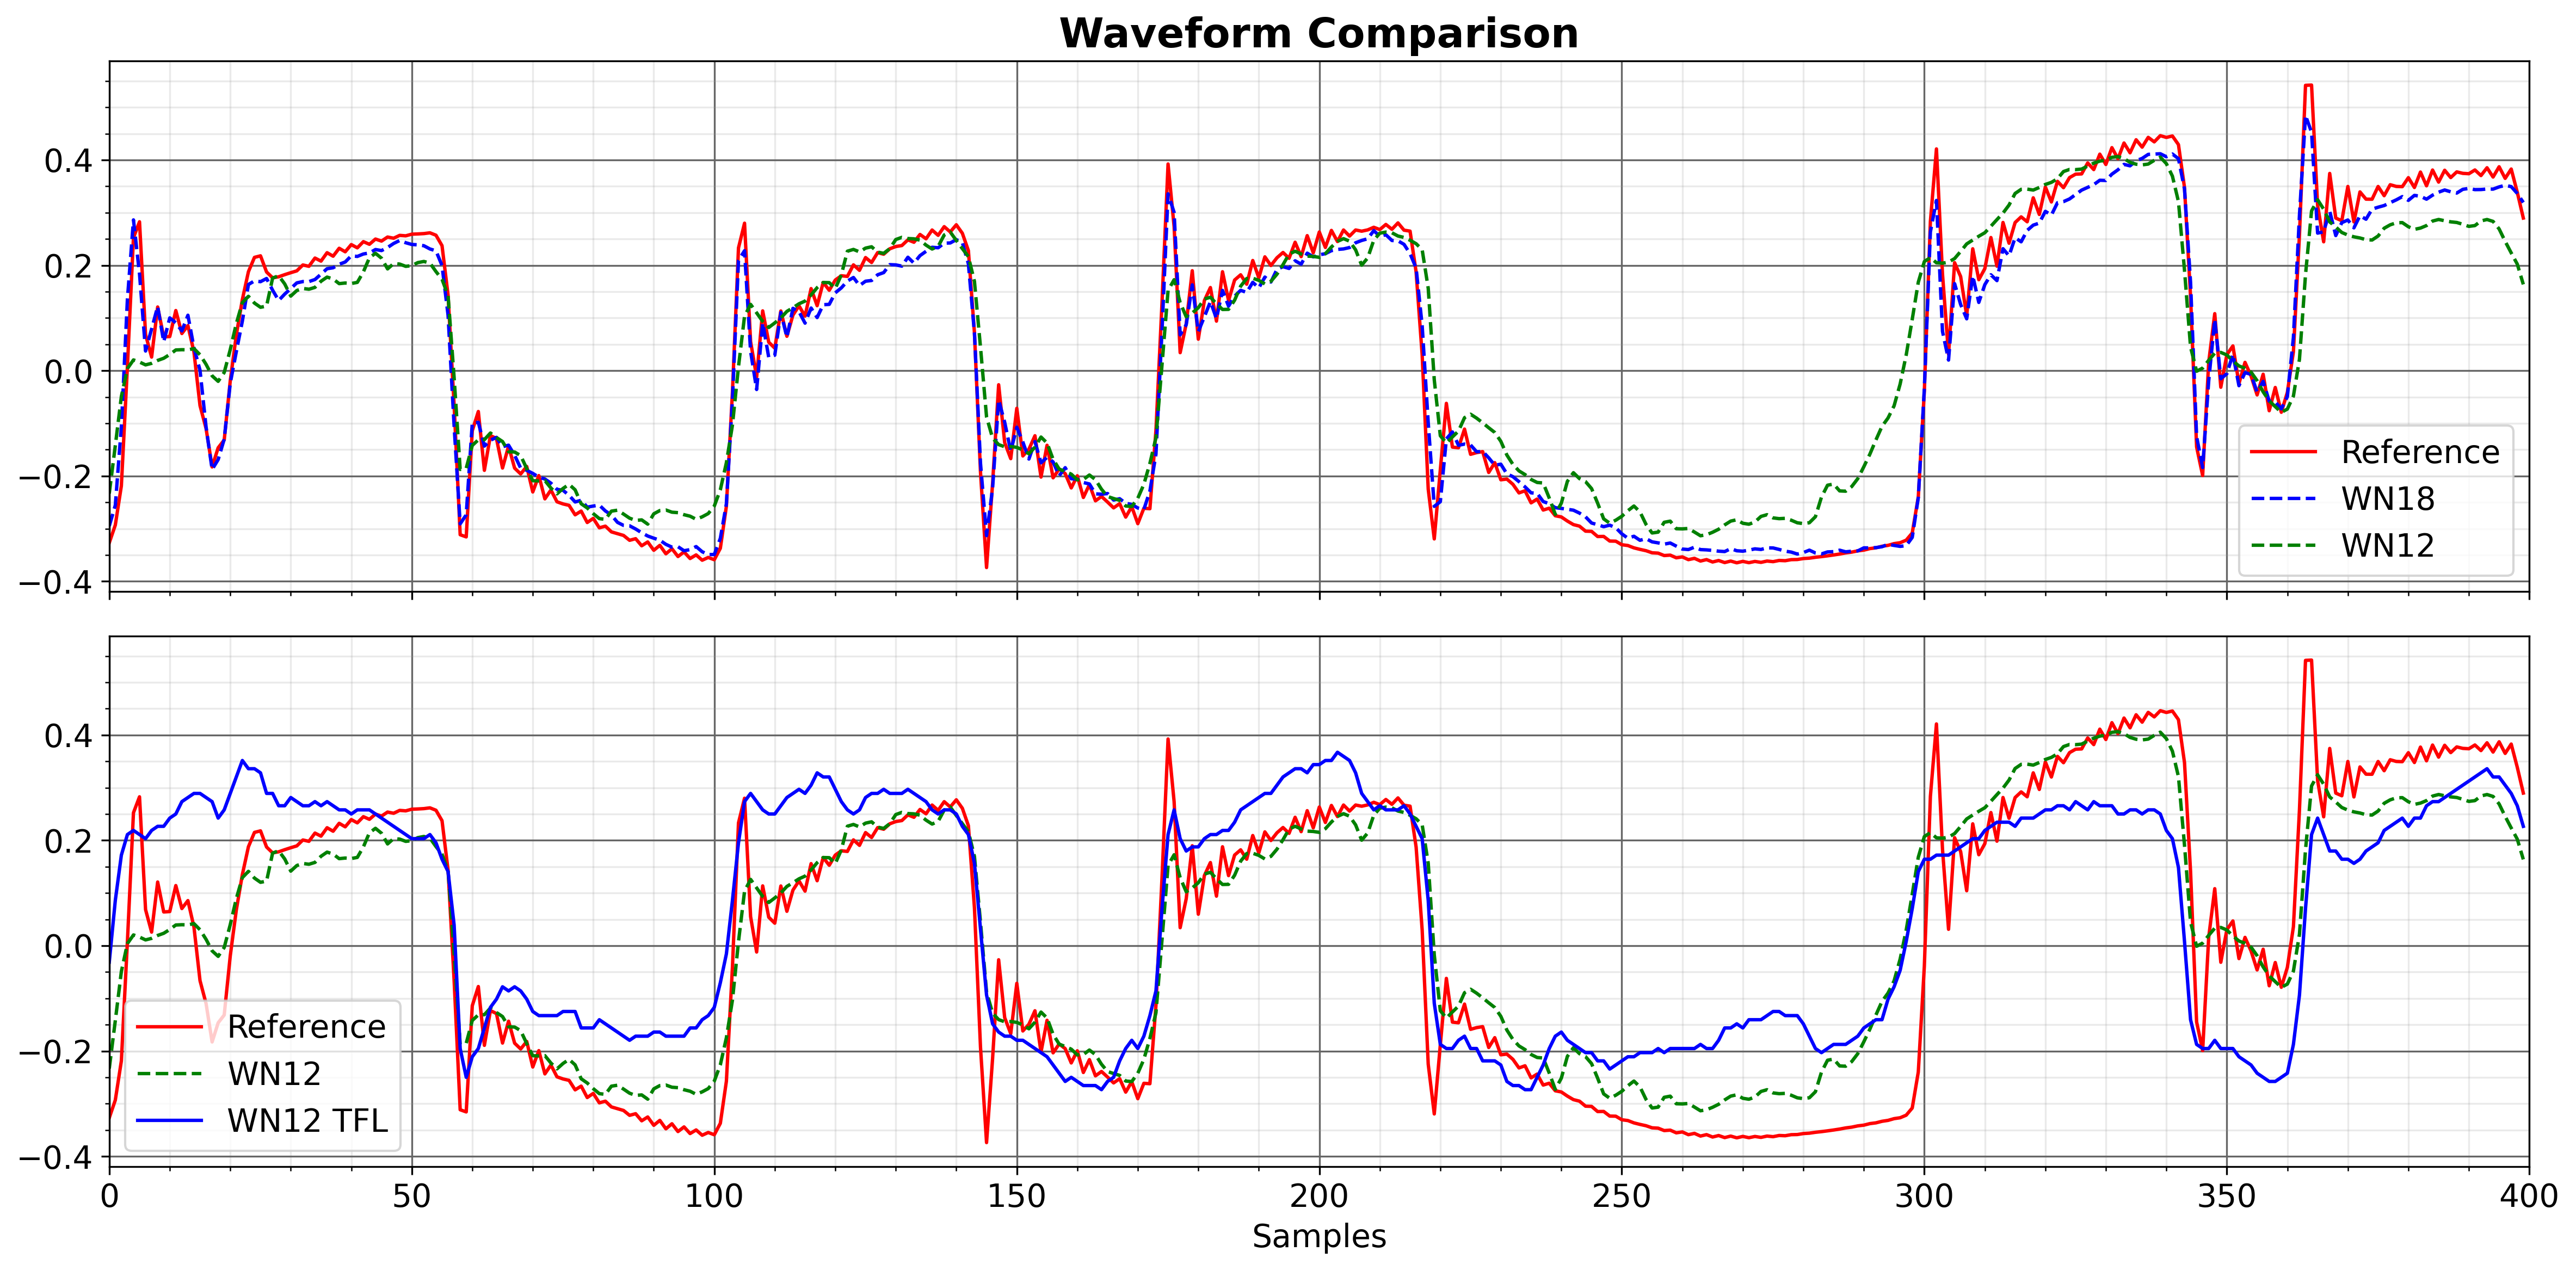

In [46]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal'}

plt.rc('font', **font)


SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE , titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='normal')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Create the figure and axes objects
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16, 8), dpi=300, sharex=True)
ax1.set_title('Waveform Comparison')
ax1.set_xlim(0, STOP-START)

# Plot the data
ax1.plot(test_audio_amp[START:STOP], 'r-', label="Reference")
ax1.plot(output_1[:STOP-START], 'b--', label="WN18")
ax1.plot(output_2[:STOP-START], 'g--', label="WN12")

ax2.plot(test_audio_amp[START:STOP], 'r-', label="Reference")
ax2.plot(output_2[:STOP-START], 'g--', label="WN12")
ax2.plot(tf_outputs[1][START:STOP], 'b', label="WN12 TFL")
#ax2.plot(tf_outputs[0][START:STOP], 'k--', label="WN12 TFL")

# Show the major grid lines with dark grey lines
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax2.grid(b=True, which='major', color='#666666', linestyle='-')

# Show the minor grid lines with very faint and almost transparent grey lines
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax2.set_xlabel("Samples")
ax1.legend()
ax2.legend()

fig.tight_layout()
plt.show()


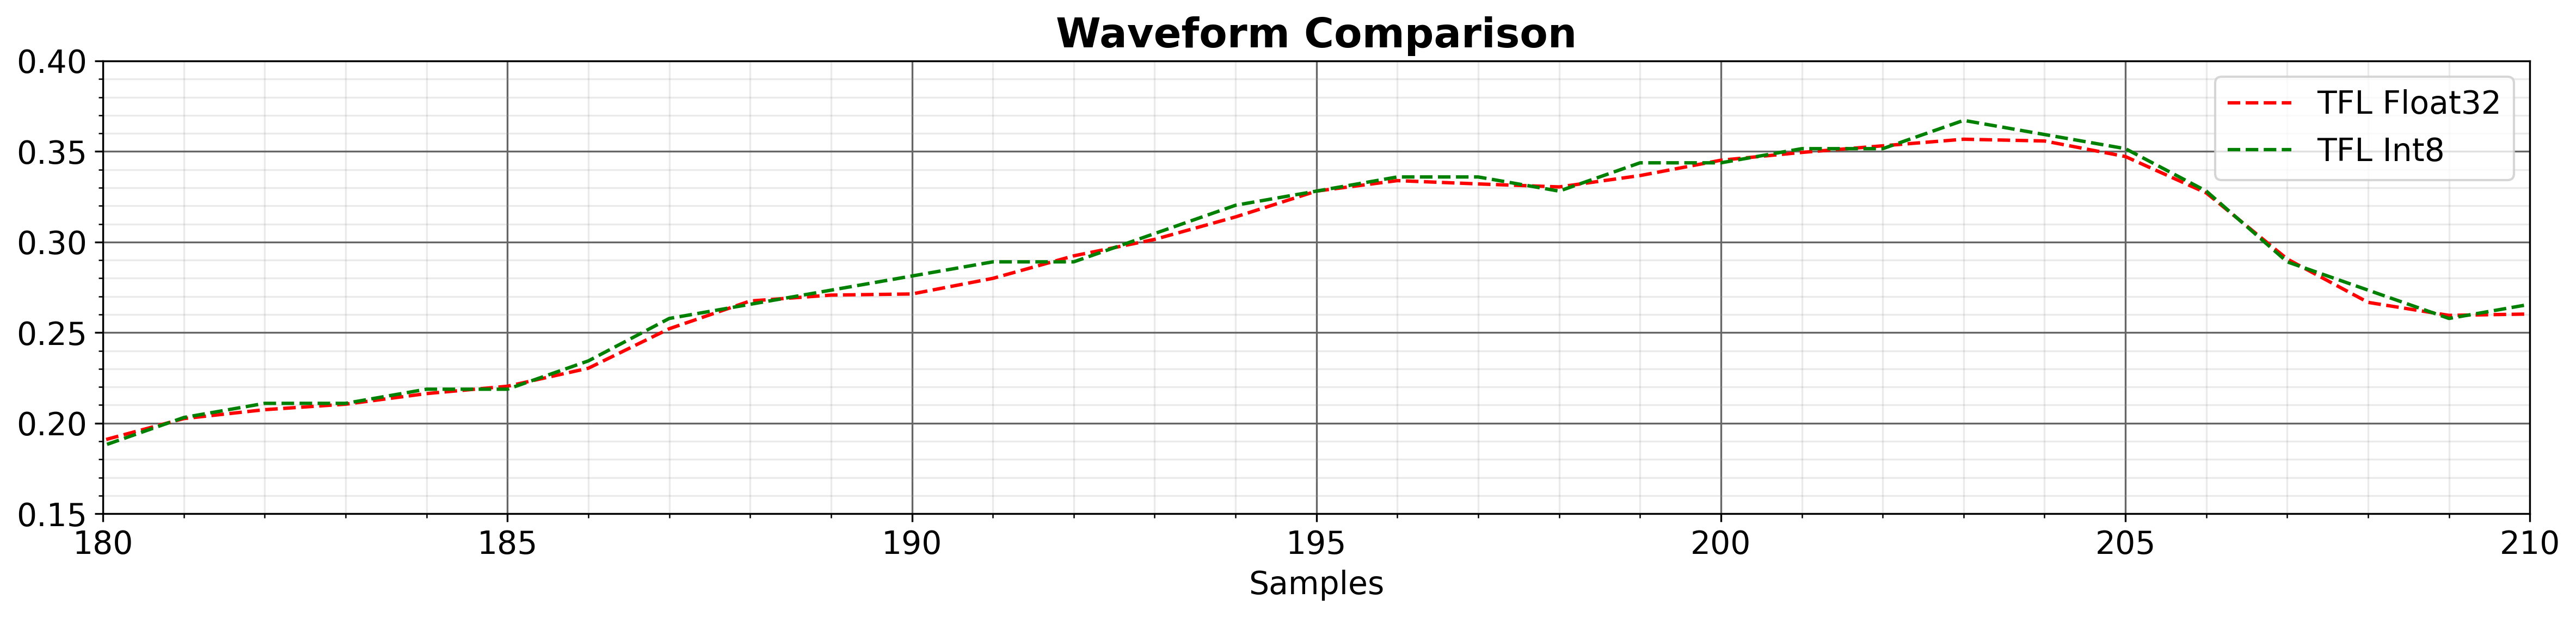

In [49]:
# Create the figure and axes objects
fig, ax1 = plt.subplots(1, figsize=(16, 4), dpi=300)
ax1.set_title('Waveform Comparison')
ax1.set_xlim(180, 210)
ax1.set_ylim(0.15,0.4)

# Plot the data
ax1.plot(tf_outputs[0][START:STOP], 'r--', label="TFL Float32")
ax1.plot(tf_outputs[1][START:STOP], 'g--', label="TFL Int8")

# Show the major grid lines with dark grey lines
ax1.grid(b=True, which='major', color='#666666', linestyle='-')

# Show the minor grid lines with very faint and almost transparent grey lines
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_xlabel("Samples")
ax1.legend()
ax2.legend()

fig.tight_layout()
plt.show()


In [ ]:
labels = ['No Dilation', 'Dilation']
time_float32  = [19.5, 13.0]
time_int8     = [32.2, 42.6]
macc_float32  = [19.5, 13.0]
macc_int8     = [32.2, 42.6]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
rects1 = ax.bar(x - width, data_float32, width, label='TFL Float32')
rects2 = ax.bar(x, data_float32_cube, width, label='X-Cube-AI Float32')
rects3 = ax.bar(x + width, data_int8, width, label='TFL Int8')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Inference Time [ms]')
ax.set_title('Optimization Level')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.grid(b=True, axis='y', which='major', color='#666666', linestyle='-', alpha=0.2)
ax.minorticks_on()
ax.grid(b=True, axis='y', which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

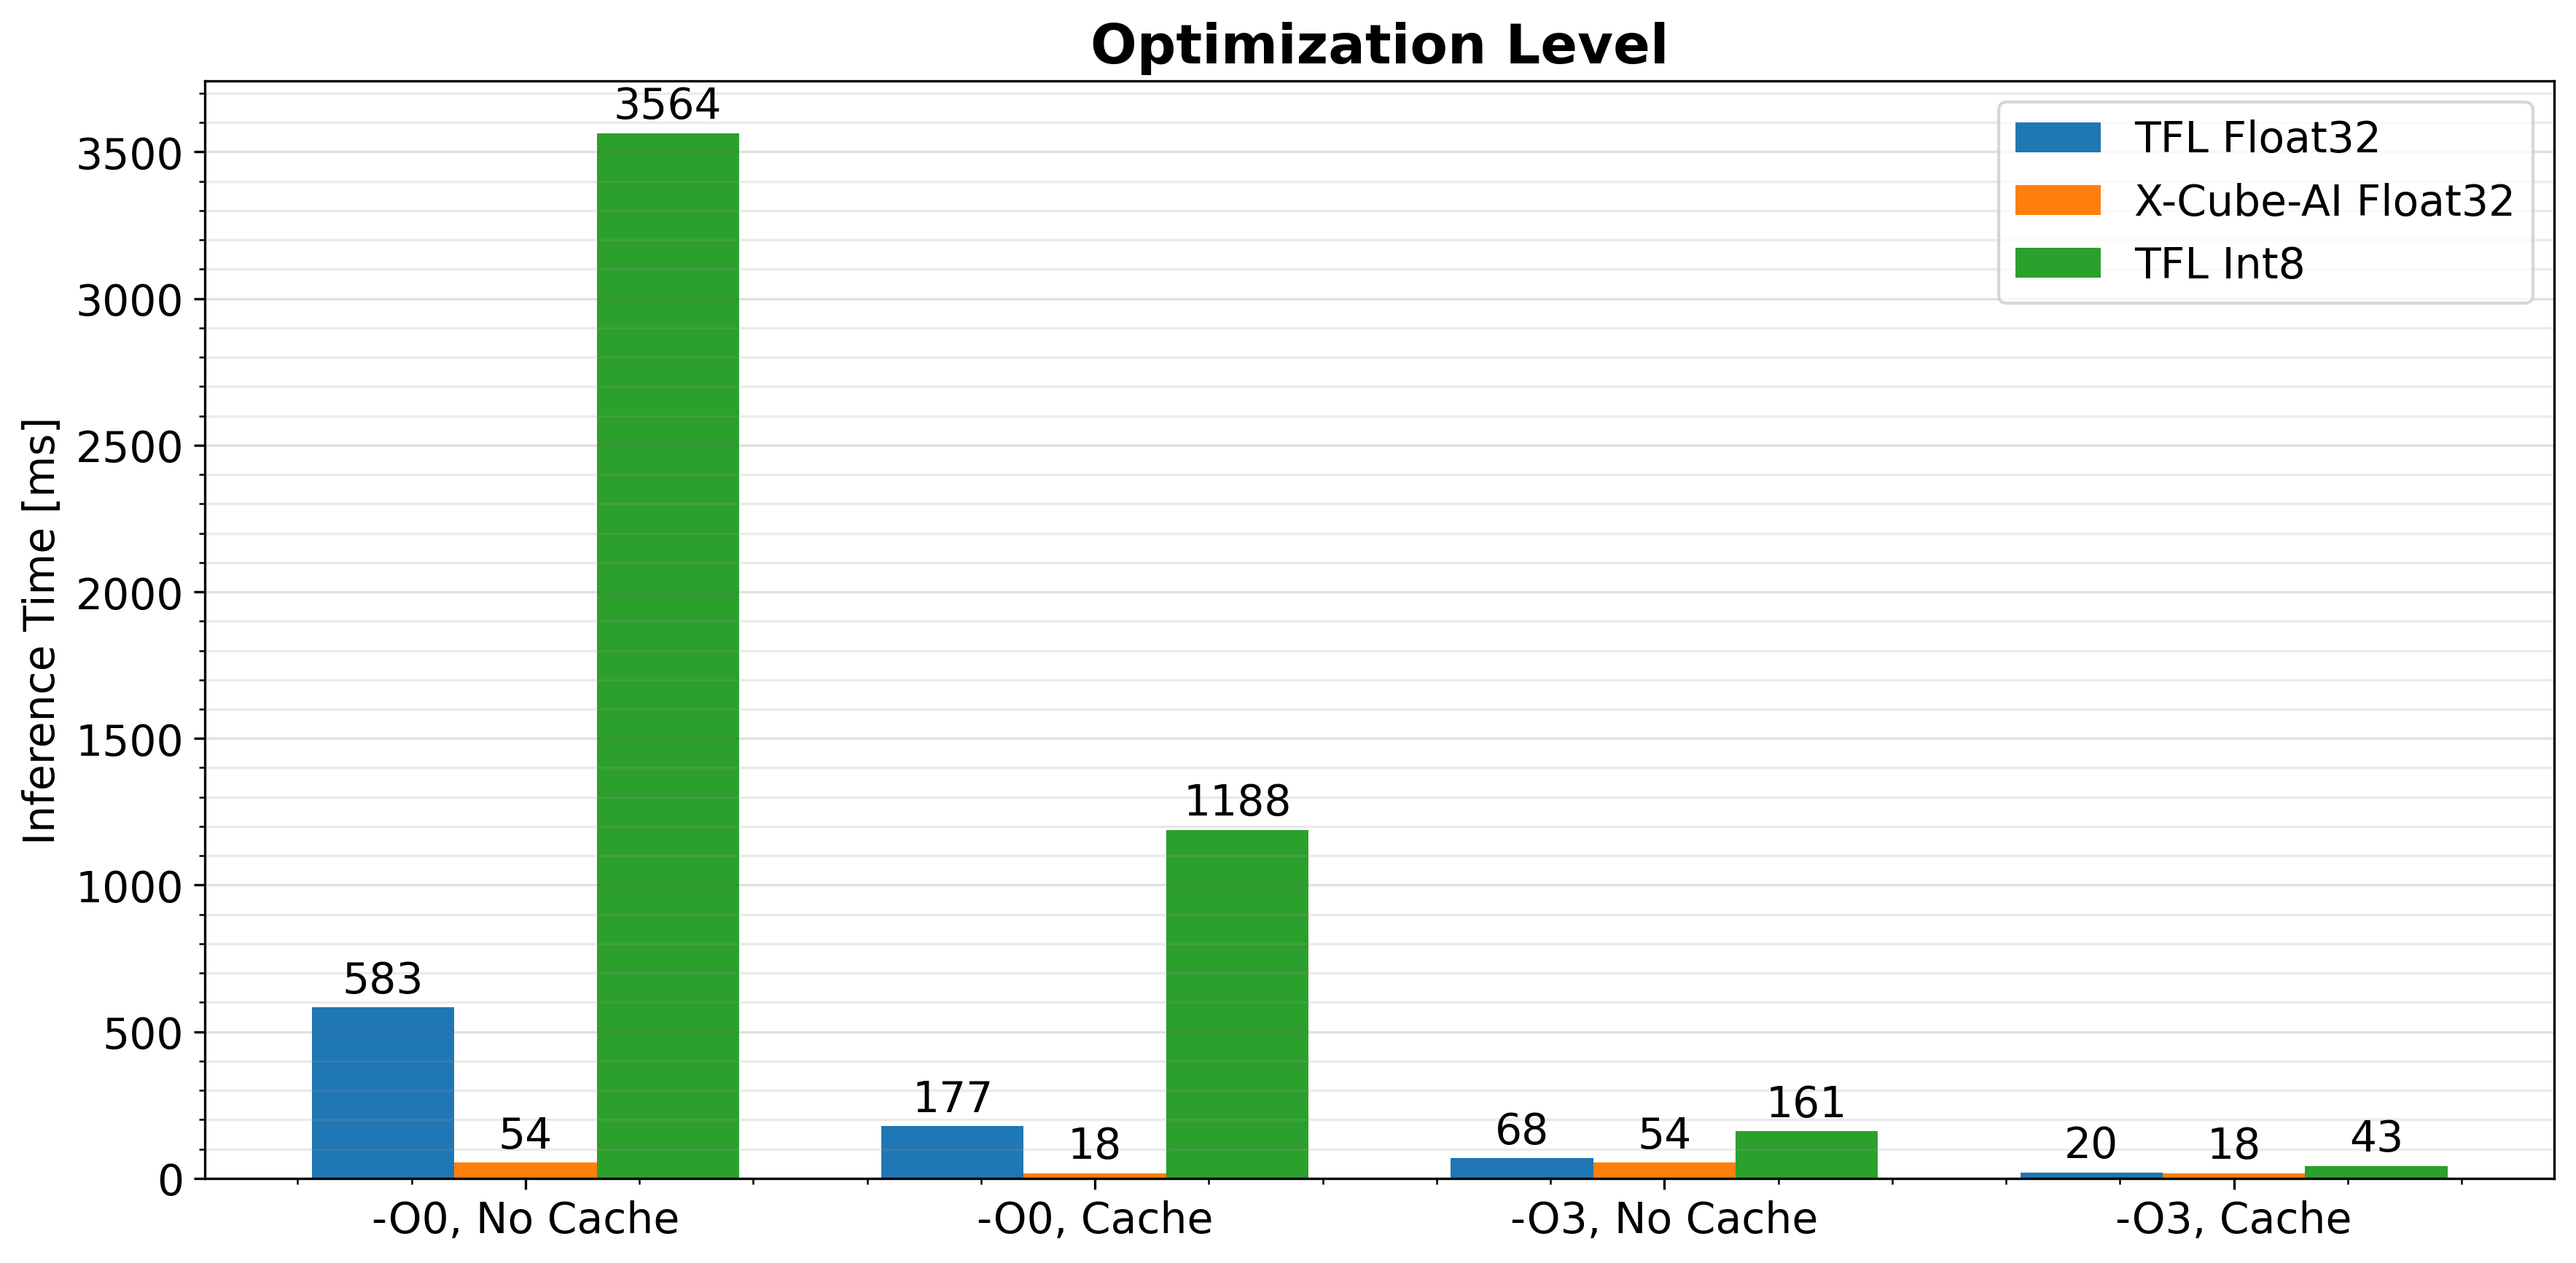

In [83]:
labels = ['-O0, No Cache', '-O0, Cache', '-O3, No Cache', '-O3, Cache']
data_float32_tfl  = [582.85, 177.30, 68.00, 20.30]
data_int8_tfl     = [3563.90, 1188.34, 161.02, 42.68]
data_float32_cube = [54.40, 18.05, 54.40, 18.05]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
rects1 = ax.bar(x - width, data_float32, width, label='TFL Float32')
rects2 = ax.bar(x, data_float32_cube, width, label='X-Cube-AI Float32')
rects3 = ax.bar(x + width, data_int8, width, label='TFL Int8')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Inference Time [ms]')
ax.set_title('Optimization Level')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.grid(b=True, axis='y', which='major', color='#666666', linestyle='-', alpha=0.2)
ax.minorticks_on()
ax.grid(b=True, axis='y', which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()